CONTENTS:
- [Exploratory Data Analysis: EIA Metadata](#exploratory-data-analysis:-eia-metadata)
  - [Introduction](#introduction)
  - [Imports](#imports)
  - [Helper Functions](#helper-functions)
  - [Load and Preprocess Data](#load-and-preprocess-data)
  - [Introductory Analytics](#introductory-analytics)
    - [Preview Data](#preview-data)
      - [EIA Metadata Index Column information](#eia-metadata-index-column-information)
      - [EIA Parameters Column information](#eia-parameters-column-information)
    - [Missing Data](#missing-data)
  - [Exploratory Analysis](#exploratory-analysis)
    - [Index Analysis](#index-analysis)
      - [Distribution by Dataset](#distribution-by-dataset)
      - [Distribution by Frequency](#distribution-by-frequency)
      - [Distribution by Unit](#distribution-by-unit)
      - [Temporal Resolution Coverage by Dataset](#temporal-resolution-coverage-by-dataset)
    - [Coverage Analysis](#coverage-analysis)
      - [Distribution by Timespan (Years)](#distribution-by-timespan-(years))
      - [Distribution by Time Series Start Period](#distribution-by-time-series-start-period)
      - [Distribution by Time Series End Period](#distribution-by-time-series-end-period)
    - [Facet Analysis](#facet-analysis)
      - [Top Facets](#top-facets)
      - [Facet Usage Across Dataset](#facet-usage-across-dataset)
      - [Facet Cardinalities](#facet-cardinalities)
    - [Summary Dataset](#summary-dataset)
      - [Summary Dataset Overview](#summary-dataset-overview)
      - [Unit Distribution in the Summary Dataset](#unit-distribution-in-the-summary-dataset)

<a name='exploratory-data-analysis:-eia-metadata'></a>
# Exploratory Data Analysis: EIA Metadata

<a name='introduction'></a>
## Introduction

This notebook analyzes the U.S. Energy Information Administration (EIA) electricity metadata retrieved from the v2 API. The goal is to understand how time series are structured across datasets, frequencies, and facet dimensions to support downstream data exploration and analysis.

<a name='imports'></a>
## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import ast
import io
import logging
import os
from typing import Dict, List, Tuple

import helpers.hdbg as hdbg
import helpers.hprint as hprint
import helpers.hs3 as hs3
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import causal_automl.eda_utils as caueduti

In [2]:
# Configure logger.
hdbg.init_logger(verbosity=logging.INFO)
_LOG = logging.getLogger(__name__)

# Configure the notebook style.
hprint.config_notebook()
sns.set_theme(style="whitegrid")

INFO  > cmd='/venv/lib/python3.12/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-065cb487-db92-45a2-9574-47dfe2705aae.json'


In [3]:
# Configure S3.
s3_dir = "s3://causify-data-collaborators/causal_automl/metadata/"
aws_profile = "ck"

<a name='helper-functions'></a>
## Helper Functions

In [4]:
def _get_missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Get a summary of missing value count and percentage per column.

    Only columns with missing values are included in the output.

    :param df: data to inspect
    :return: data with count and percentage of missing values
    """
    count = df.isna().sum()
    percent = df.isna().mean() * 100
    missing_count = pd.DataFrame(
        {"Missing Count": count, "Missing %": percent}
    ).sort_values(by="Missing %", ascending=False)
    missing_columns_df = missing_count[missing_count["Missing Count"] > 0]
    return missing_columns_df


def _plot_distribution(
    df_metadata: pd.DataFrame, column: str, title: str
) -> None:
    """
    Plot a distribution count for a specified metadata column.

    :param df_metadata: metadata table containing time series fields
    :param column: column to group and count values by (e.g.,
        'frequency_id', 'data_units')
    :param title: title for the plot
    """
    hdbg.dassert_in(column, df_metadata.columns, "Invalid column `%s`", column)
    counts = df_metadata[column].value_counts()
    caueduti.plot_top_n_annotated_bar(
        counts=counts,
        total=len(df_metadata),
        top_n=len(counts),
        title=title,
        xlabel=column.replace("_", " ").title(),
        ylabel="Count",
        wrap_width=35,
        rotation=30,
    )

<a name='load-and-preprocess-data'></a>
## Load and Preprocess Data

In [5]:
def _load_data(file_path: str, aws_profile: str) -> pd.DataFrame:
    """
    Load data from the specified S3 file path.

    :param file_path: full S3 URI of the file to load
    :param aws_profile: AWS CLI profile used for access
    :return: the loaded data
    """
    file = hs3.from_file(file_path, aws_profile=aws_profile)
    df = pd.read_csv(io.StringIO(file))
    return df


def _load_eia_metadata_and_parameters(
    s3_dir: str,
    metadata_file_path: str,
    parameter_subdir: str,
    aws_profile: str,
) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]:
    """
    Load EIA metadata and parameter files from S3.

    :param s3_dir: base S3 directory (e.g., "s3://mybucket/data/")
    :param metadata_file: metadata CSV filename (e.g., "eia_metadata.csv")
    :param parameter_subdir: subdirectory in `s3_dir` containing parameter files
    :param aws_profile: AWS CLI profile used for access
    :return: metadata and parameter data
    """
    # Load metadata CSV.
    metadata_path = os.path.join(s3_dir, metadata_file_path)
    df_metadata = _load_data(metadata_path, aws_profile)
    # Load all parameter CSVs.
    parameter_dir = os.path.join(s3_dir, parameter_subdir)
    s3fs_ = hs3.get_s3fs(aws_profile)
    param_paths = s3fs_.ls(parameter_dir)
    param_dfs = {}
    for path in param_paths:
        if path.endswith(".csv"):
            key = os.path.basename(path).replace("_parameters.csv", "")
            full_path = f"s3://{path}"
            param_dfs[key] = _load_data(full_path, aws_profile)
    return df_metadata, param_dfs


def _normalize_facets(facets: List[Dict[str, str]]) -> List[Dict[str, str]]:
    """
    Normalize similar facet values.

    :param facets: facets to process
    :return: normalized facets
    """
    for facet in facets:
        if facet["id"].lower() in {"state", "stateid", "stateID", "location"}:
            facet["id"] = "stateid"
    return facets


def _preprocess_eia(
    df_metadata: pd.DataFrame,
    param_dfs: Dict[str, pd.DataFrame],
) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]:
    """
    Preprocess metadata and parameter data for analysis.

    :param df_metadata: metadata index data
    :param param_dfs: parameter data
    :return: cleaned metadata and parameter data
    """
    # Preprocess metadata.
    df_metadata["frequency_id"] = (
        df_metadata["frequency_id"].str.lower().str.strip()
    )
    # Parse facets column if stored as string.
    df_metadata["facets"] = df_metadata["facets"].apply(ast.literal_eval)
    # Normalize similar variables.
    df_metadata["facets"] = df_metadata["facets"].map(_normalize_facets)
    # Preprocess parameters.
    param_dfs_cleaned = {}
    for file_name, df_param in param_dfs.items():
        df_param_cleaned = df_param.copy()
        # Standardized field with normalized variables.
        df_param_cleaned["facet_id"] = (
            df_param_cleaned["facet_id"]
            .astype(str)
            .str.strip()
            .str.lower()
            .replace(
                {"state": "stateid", "stateID": "stateid", "location": "stateid"}
            )
        )
        # Strip whitespace from id field.
        df_param_cleaned["id"] = df_param_cleaned["id"].astype(str).str.strip()
        param_dfs_cleaned[file_name] = df_param_cleaned
    return df_metadata, param_dfs_cleaned

In [6]:
# Load EIA metadata index and parameters.
metadata_s3_path = "eia_electricity_metadata_original_v1.0.csv"
param_s3_dir = "eia_parameters_v1.0"
df_metadata, param_dfs = _load_eia_metadata_and_parameters(
    s3_dir, metadata_s3_path, param_s3_dir, aws_profile
)
# Preprocess EIA metadata index and parameters.
df_metadata, param_dfs = _preprocess_eia(df_metadata, param_dfs)

<a name='introductory-analytics'></a>
## Introductory Analytics

<a name='preview-data'></a>
### Preview Data

In [7]:
# Preview metadata.
print(f"Number of time series: {len(df_metadata)}")
print(f"Number of columns: {df_metadata.shape[1]}")
print(f"Number of unique datasets: {df_metadata['dataset_id'].nunique()}")
df_metadata.head()

Number of time series: 172
Number of columns: 17
Number of unique datasets: 19


,url,id,dataset_id,name,description,frequency_id,frequency_alias,frequency_description,frequency_query,frequency_format,facets,data,data_alias,data_units,start_period,end_period,parameter_values_file
0,https://api.eia.gov/v2/electricity/retail-sale...,retail_sales_monthly_revenue,retail_sales,Electricity Sales to Ultimate Customers,Electricity sales to ultimate customer by stat...,monthly,NaN,One data point for each month.,M,YYYY-MM,"[{'id': 'stateid', 'description': 'State / Cen...",revenue,Revenue from Sales to Ultimate Customers,million dollars,2001-01,2025-02,eia_parameters_v1.0/retail_sales_parameters.csv
1,https://api.eia.gov/v2/electricity/retail-sale...,retail_sales_monthly_sales,retail_sales,Electricity Sales to Ultimate Customers,Electricity sales to ultimate customer by stat...,monthly,NaN,One data point for each month.,M,YYYY-MM,"[{'id': 'stateid', 'description': 'State / Cen...",sales,Megawatt-hours Sold to Ultimate Customers,million kilowatt hours,2001-01,2025-02,eia_parameters_v1.0/retail_sales_parameters.csv
2,https://api.eia.gov/v2/electricity/retail-sale...,retail_sales_monthly_price,retail_sales,Electricity Sales to Ultimate Customers,Electricity sales to ultimate customer by stat...,monthly,NaN,One data point for each month.,M,YYYY-MM,"[{'id': 'stateid', 'description': 'State / Cen...",price,Average Price of Electricity to Ultimate Custo...,cents per kilowatt-hour,2001-01,2025-02,eia_parameters_v1.0/retail_sales_parameters.csv
3,https://api.eia.gov/v2/electricity/retail-sale...,retail_sales_monthly_customers,retail_sales,Electricity Sales to Ultimate Customers,Electricity sales to ultimate customer by stat...,monthly,NaN,One data point for each month.,M,YYYY-MM,"[{'id': 'stateid', 'description': 'State / Cen...",customers,Number of Ultimate Customers,number of customers,2001-01,2025-02,eia_parameters_v1.0/retail_sales_parameters.csv
4,https://api.eia.gov/v2/electricity/retail-sale...,retail_sales_quarterly_revenue,retail_sales,Electricity Sales to Ultimate Customers,Electricity sales to ultimate customer by stat...,quarterly,NaN,One data point every 3 months.,Q,"YYYY-""Q""Q","[{'id': 'stateid', 'description': 'State / Cen...",revenue,Revenue from Sales to Ultimate Customers,million dollars,2001-01,2025-02,eia_parameters_v1.0/retail_sales_parameters.csv


<a name='eia-metadata-index-column-information'></a>
#### EIA Metadata Index Column information

| **Column**              | **Description**                                                                      |
|-------------------------|--------------------------------------------------------------------------------------|
| `url`                   | Full API URL to access the time series.                                              |
| `id`                    | Unique identifier for the time series.                                               |
| `dataset_id`            | Dataset group this series belongs to.                                                |
| `name`                  | Human-readable title of the dataset group.                                           |
| `description`           | Full description of the dataset group.                                               |
| `frequency_id`          | Frequency label (e.g. `monthly`, `quarterly`, `hourly`).                             |
| `frequency_alias`       | Alternative frequency name (often missing).                                          |
| `frequency_description` | Sentence-style explanation of frequency (e.g. "One data point for each month").      |
| `frequency_query`       | Query shorthand for frequency (e.g. `M` for monthly).                                |
| `frequency_format`      | Formatting string used in time index.                                                |
| `facets`                | JSON-style list of facet definitions used for filtering (e.g. `stateid`, `sectorid`).|
| `data`                  | Identifier for the metric being measured (e.g. `combined-heat-and-pwr-comm`).        |
| `data_alias`            | Display-friendly name for the metric (e.g. `Net Generation from Commercial Sector`). |
| `data_units`            | Units of measurement (e.g. `million dollars`, `cents per kWh`).                      |
| `start_period`          | Start date of available data (YYYY-MM format).                                       |
| `end_period`            | End date of available data (YYYY-MM format).                                         |
| `parameter_values_file` | S3 path to facet value mappings for this dataset.                                    |


In [8]:
# Available parameter datasets.
print("Available parameter datasets:")
for name in sorted(param_dfs.keys()):
    print(f"- {name}")
# Preview one parameter file.
param_dfs["retail_sales"].head()

Available parameter datasets:
- capability
- daily_fuel_type_data
- daily_interchange_data
- daily_region_data
- daily_region_sub_ba_data
- electric_power_operational_data
- emissions_by_state_by_fuel
- energy_efficiency
- facility_fuel
- fuel_type_data
- interchange_data
- meters
- net_metering
- operating_generator_capacity
- region_data
- region_sub_ba_data
- retail_sales
- source_disposition
- summary


,dataset_id,facet_id,id,name,alias
0,retail_sales,stateid,IN,Indiana,(IN) Indiana
1,retail_sales,stateid,KS,Kansas,(KS) Kansas
2,retail_sales,stateid,MAT,Middle Atlantic,Region: (MAT) Middle Atlantic
3,retail_sales,stateid,CT,Connecticut,(CT) Connecticut
4,retail_sales,stateid,VA,Virginia,(VA) Virginia


<a name='eia-parameters-column-information'></a>
#### EIA Parameters Column information

| **Column**         | **Description**                                                                 |
|--------------------|---------------------------------------------------------------------------------|
| `dataset_id`       | Name of the parent dataset this parameter file belongs to (e.g. `retail_sales`). |
| `facet_id`         | The dimension or facet described (e.g. `stateid`, `sectorid`).                   |
| `id`               | The unique code or shorthand for the facet value (e.g. `CA`, `RES`).             |
| `name`             | Plain name of the facet value (e.g. `California`, `residential`).                |
| `alias`            | Display-friendly name or formatted version of the value.                |


<a name='missing-data'></a>
### Missing Data

,Missing Count,Missing %
frequency_alias,164,95.348837
data_units,62,36.046512
data_alias,1,0.581395


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Missing Values per Column'}, xlabel='Column', ylabel='Missing Count'>)

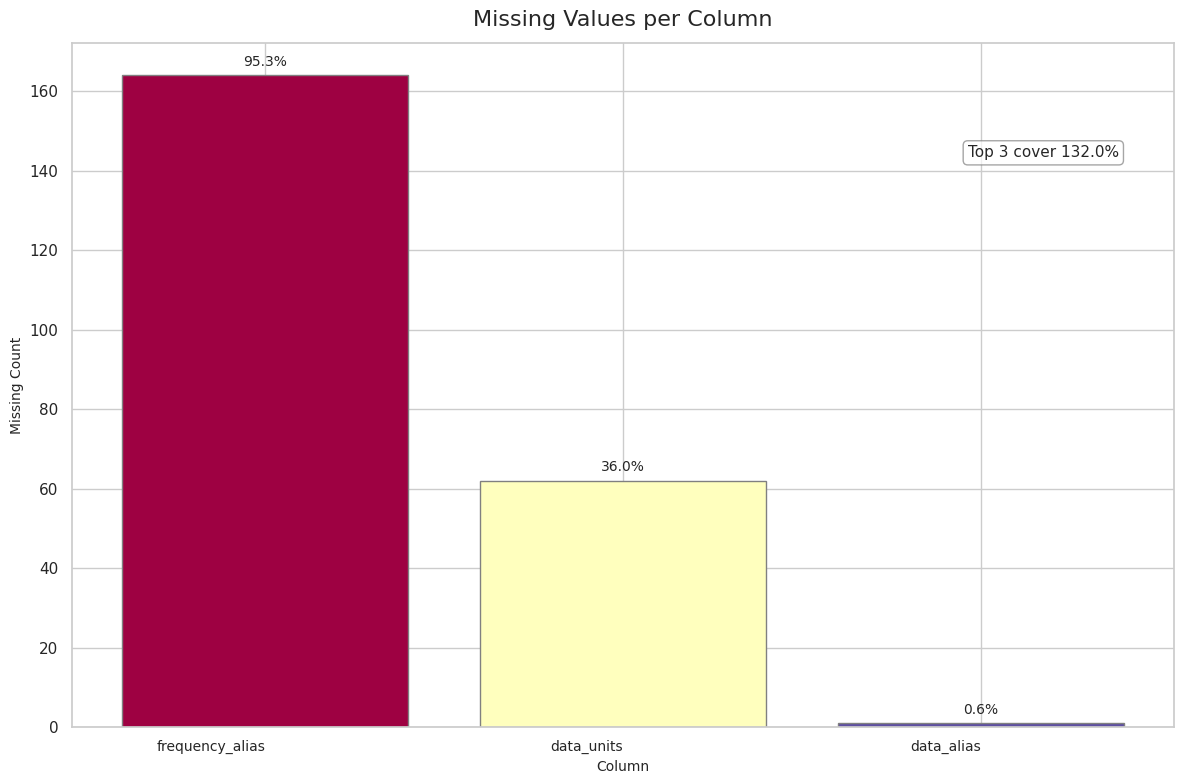

In [9]:
# Calculate missing counts and percentages.
missing_count = _get_missing_summary(df_metadata)
display(missing_count)
# Plot percentage of missing value.
caueduti.plot_top_n_annotated_bar(
    counts=missing_count["Missing Count"],
    total=len(df_metadata),
    top_n=len(missing_count),
    title="Missing Values per Column",
    xlabel="Column",
    ylabel="Missing Count",
    wrap_width=None,
    rotation=0,
)

Only three columns contain missing values: `frequency_alias`, `data_units`, and `data_alias`, with 95.3%, 36.0% and 0.6% missing values respectively. The missing `frequency_alias` and `data_alias` are not essential, as they serve only as display-friendly labels. While `data_units` is more relevant for interpreting values (e.g., whether a series is in MW or MWh), it is often redundant with dataset context and not required for structural analysis.

<a name='exploratory-analysis'></a>
## Exploratory Analysis

<a name='index-analysis'></a>
### Index Analysis

<a name='distribution-by-dataset'></a>
#### Distribution by Dataset

The time series in the EIA electricity metadata originate from 19 distinct datasets, with the majority concentrated in a few categories. Notably, `electric_power_operational_data` and `summary` together account for nearly half of all parameter entries, suggesting they are the most comprehensive or widely used sources. In contrast, many other datasets contribute only a small number of entries, suggesting they are more specialized or narrowly scoped. This skewed distribution highlights key datasets likely to dominate downstream analysis.

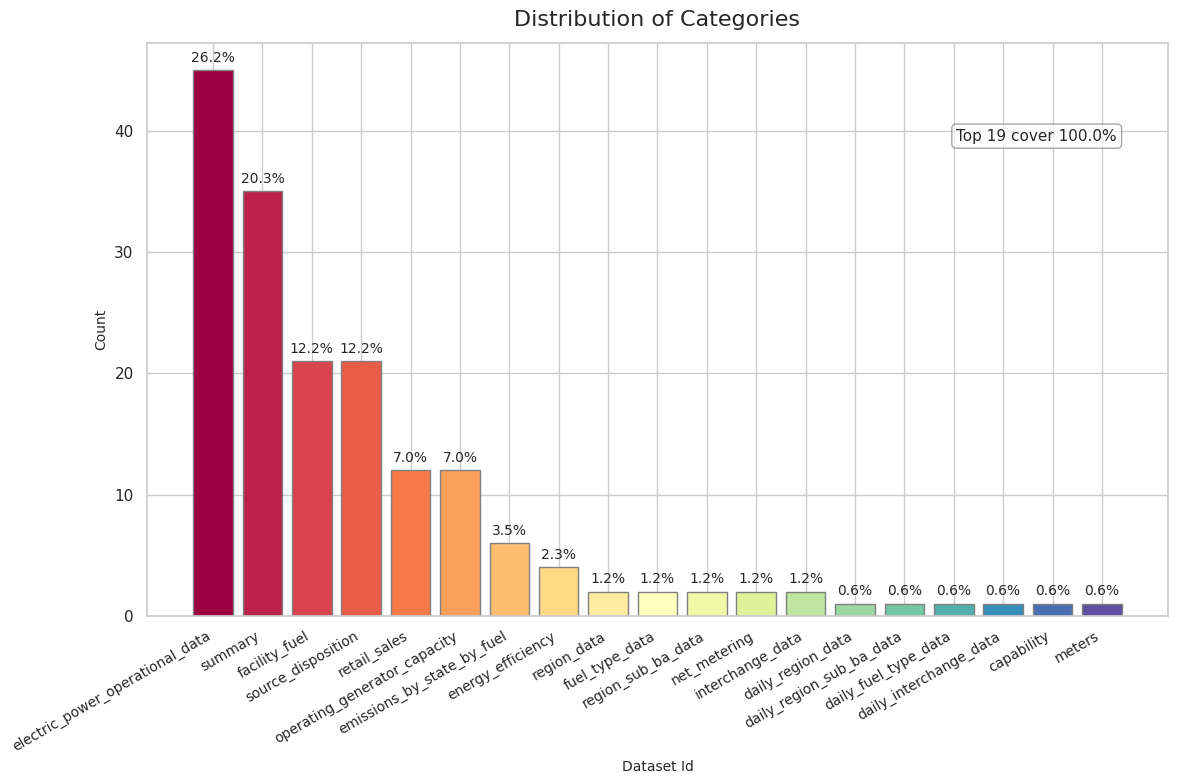

In [10]:
_plot_distribution(df_metadata, "dataset_id", "Distribution of Categories")

<a name='distribution-by-frequency'></a>
#### Distribution by Frequency

The dataset predominantly consists of annual (55.8%), monthly (22.1%), and quarterly (15.1%) time series, which together account for over 93% of the metadata. High-frequency data such as hourly and daily are rare, indicating the EIA primarily publishes coarse-grained electricity statistics rather than fine-grained real-time series.

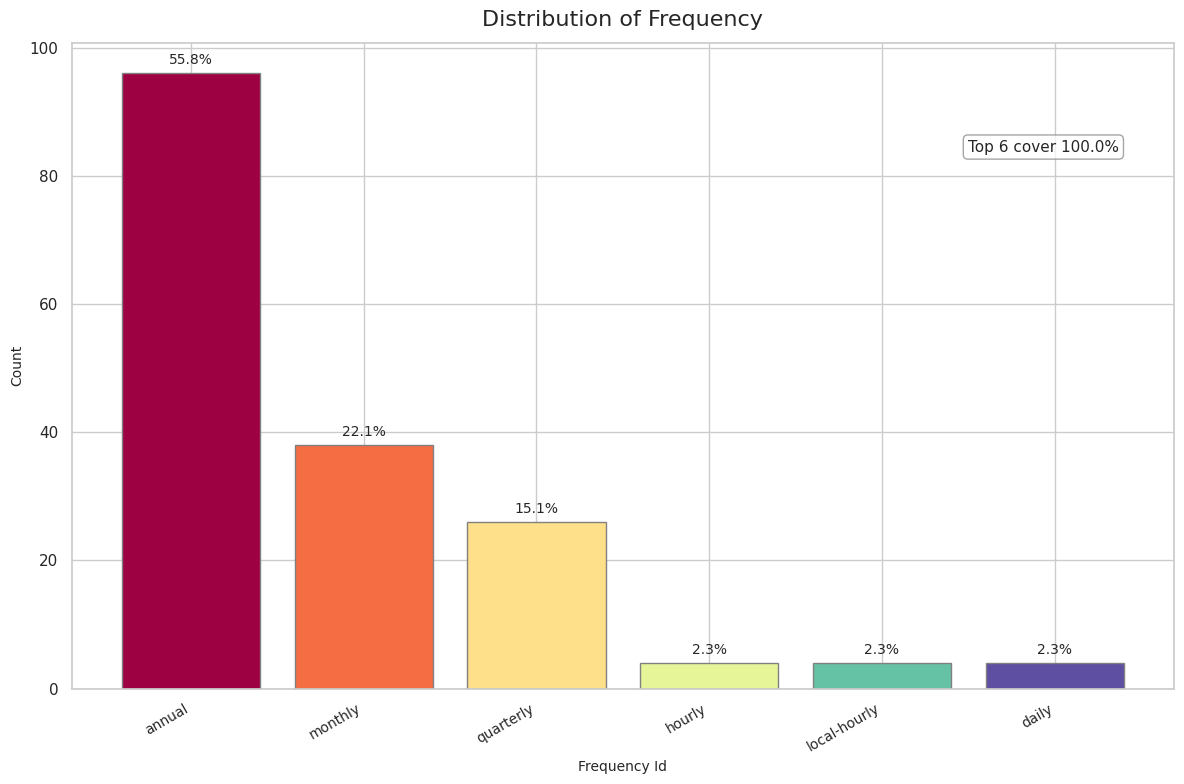

In [11]:
_plot_distribution(df_metadata, "frequency_id", "Distribution of Frequency")

<a name='distribution-by-unit'></a>
#### Distribution by Unit

The EIA electricity metadata is dominated by energy-related units, with `megawatthours` alone accounting for 26.7% of all time series. The top 16 units cover 64% of the data, indicating a moderate concentration across physical, economic, and environmental metrics. This suggests the dataset primarily captures electricity usage and generation, but also includes financial and emissions indicators. Analysts should be mindful of unit differences when comparing or aggregating series.

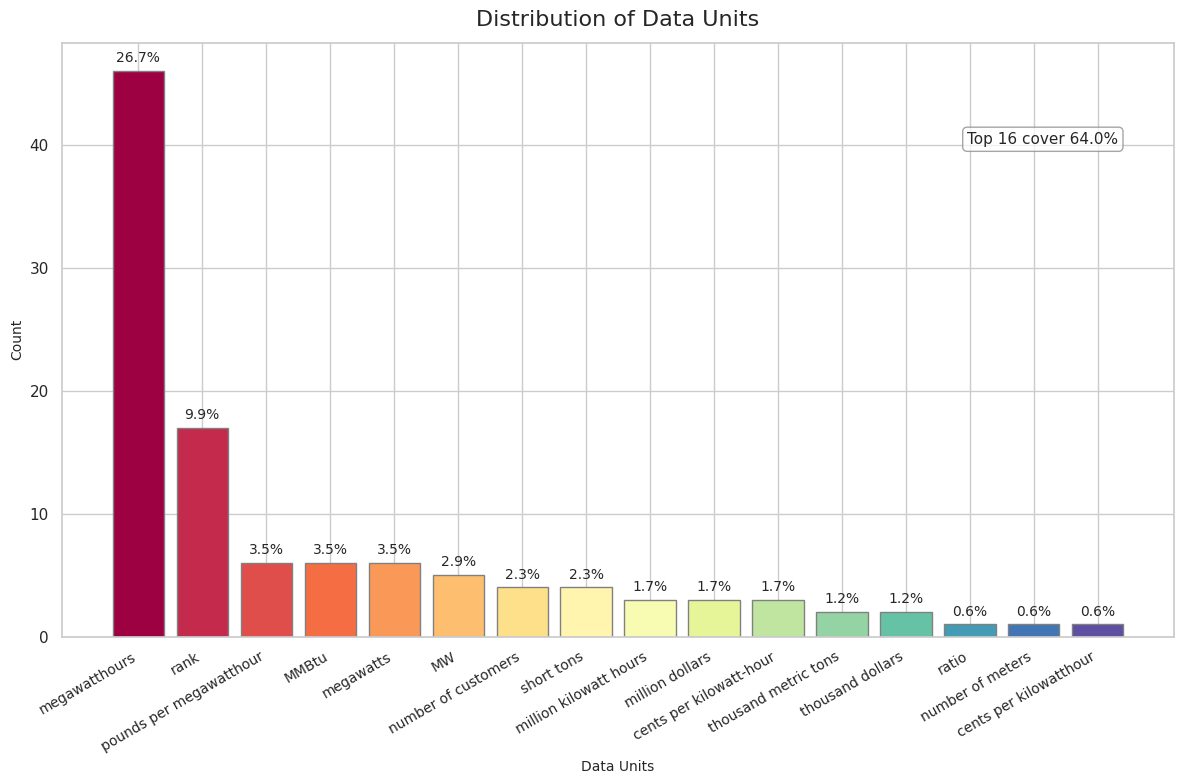

In [12]:
_plot_distribution(df_metadata, "data_units", "Distribution of Data Units")

<a name='temporal-resolution-coverage-by-dataset'></a>
#### Temporal Resolution Coverage by Dataset

This heatmap shows the distribution of time series across combinations of `dataset_id` and `frequency_id`.

- Most datasets report data at `monthly` frequency.

- A few datasets, like `daily_region_data` or `daily_fuel_type_data`, are specifically tailored for daily reporting.

- Some datasets support multiple frequencies, indicating they may be used across short-term and long-term analyses.

- Datasets such as `capability`, `summary`, and `net_metering` have limited frequency options, typically annual or yearly, suggesting a more strategic rather than operational nature.

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Heatmap of Dataset vs Frequency'}, xlabel='Frequency ID', ylabel='Dataset ID'>)

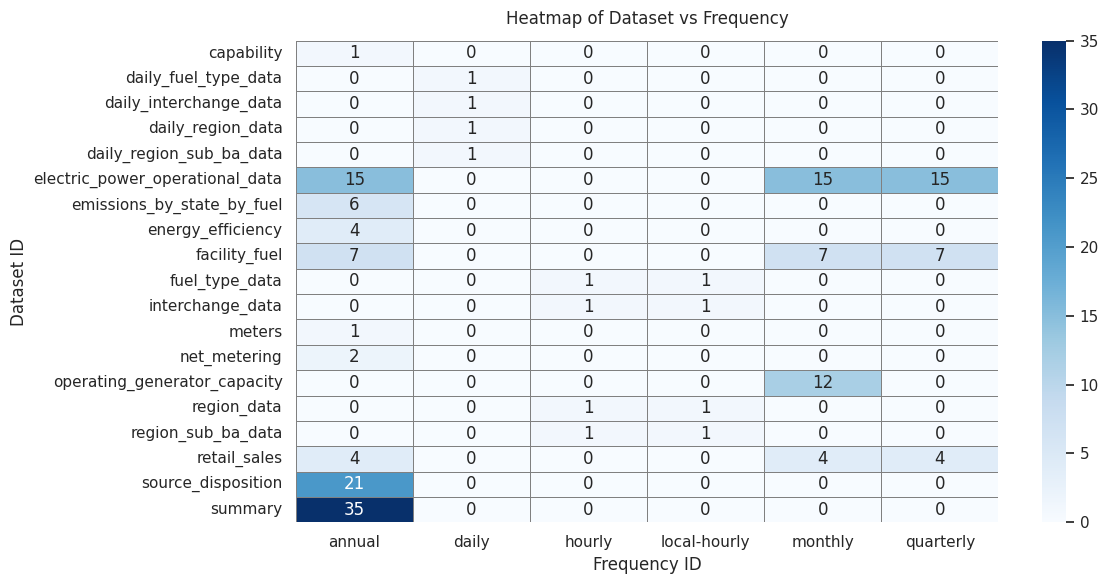

In [13]:
# Generate dataset and frequency crosstab.
dataset_frequency_crosstab = pd.crosstab(
    df_metadata["dataset_id"], df_metadata["frequency_id"]
)
# Plot heatmap of dataset against frequency.
caueduti.plot_heatmap(
    dataset_frequency_crosstab,
    title="Heatmap of Dataset vs Frequency",
    xlabel="Frequency ID",
    ylabel="Dataset ID",
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    linecolor="gray",
    figsize=(12, 6),
)

<a name='coverage-analysis'></a>
### Coverage Analysis

<a name='distribution-by-timespan-(years)'></a>
#### Distribution by Timespan (Years)

Most time series in the dataset span around 25 years, indicating strong long-term data coverage. There are smaller peaks at approximately 15 and 33 years, suggesting that some datasets began earlier or were added more recently. Very few time series have less than 10 years of data, making this collection well-suited for historical trend analysis. The consistency in duration enhances its utility for longitudinal studies and forecasting tasks.

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Distribution of Timespan (Years)'}, xlabel='Years of Coverage', ylabel='Count'>)

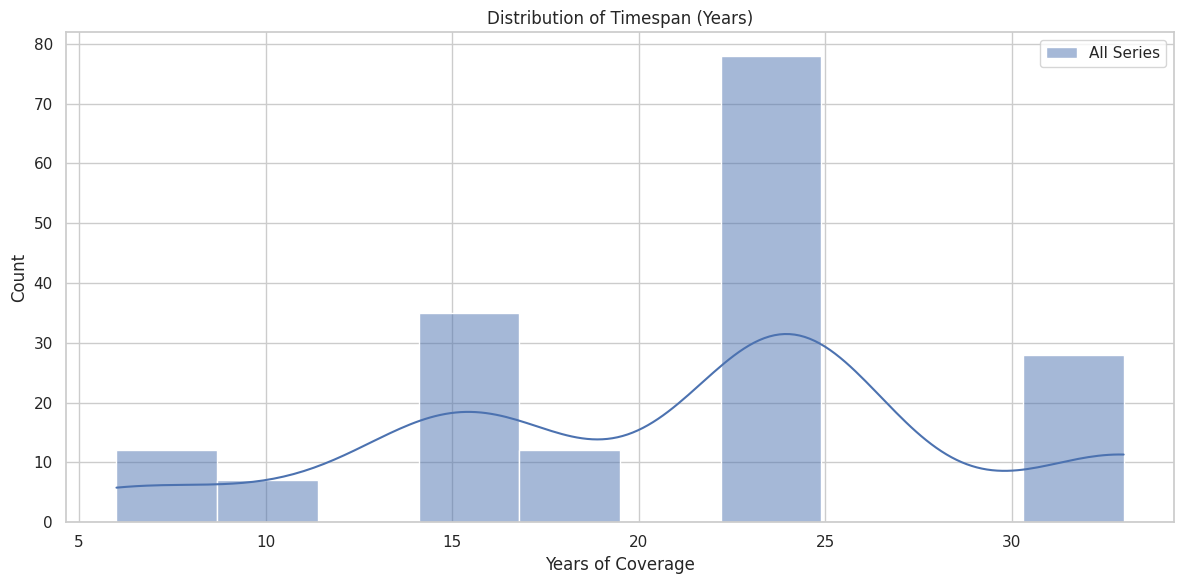

In [14]:
# Compute time span.
df_metadata["start_period_year"] = (
    df_metadata["start_period"].str.extract(r"(\d{4})").astype(int)
)
df_metadata["end_period_year"] = (
    df_metadata["end_period"].str.extract(r"(\d{4})").astype(int)
)
df_metadata["timespan_years"] = (
    df_metadata["end_period_year"] - df_metadata["start_period_year"]
)
# Plot histogram of time spans.
caueduti.plot_histograms(
    data_series=[df_metadata["timespan_years"]],
    labels=["All Series"],
    colors=["C0"],
    bins=10,
    xlabel="Years of Coverage",
    title="Distribution of Timespan (Years)",
    figsize=(12, 6),
)

<a name='distribution-by-time-series-start-period'></a>
#### Distribution by Time Series Start Period

The distribution shows that most time series began around 2000–2001, suggesting a major expansion or standardization effort during that period. A smaller spike appears in 2008, possibly tied to policy or market shifts. After 2010, new series became increasingly rare, indicating a stabilization in data collection. Very few series started before 1995, likely due to limited historical digitization.

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Distribution of Time Series Start Year'}, xlabel='Year', ylabel='Count'>)

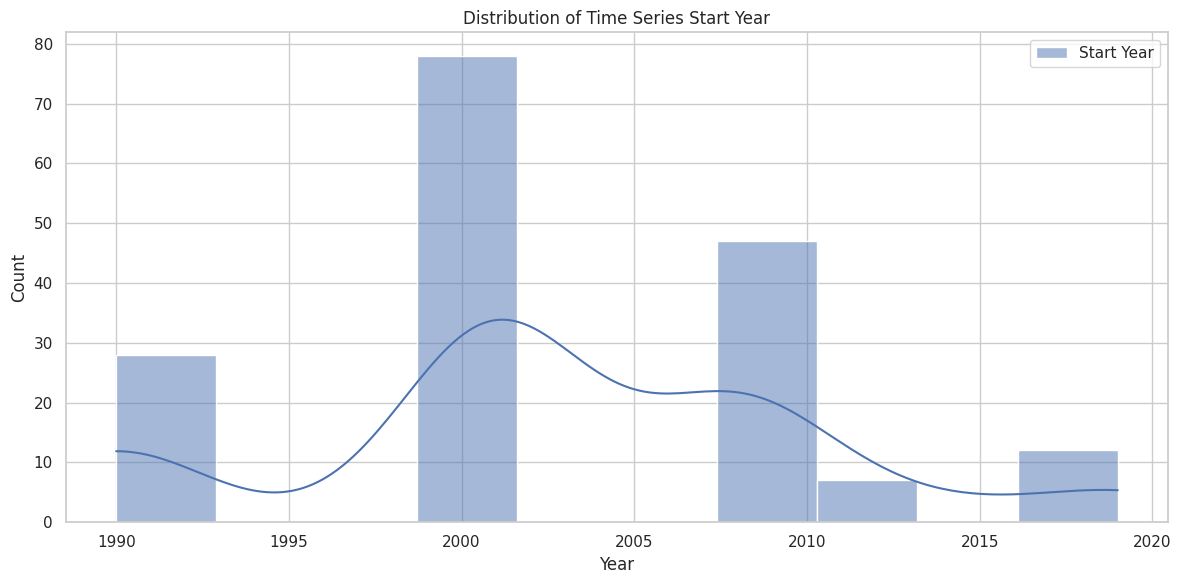

In [15]:
caueduti.plot_histograms(
    data_series=[df_metadata["start_period_year"]],
    labels=["Start Year"],
    colors=["C0"],
    bins=10,
    kde=True,
    xlabel="Year",
    title="Distribution of Time Series Start Year",
    figsize=(12, 6),
)

<a name='distribution-by-time-series-end-period'></a>
#### Distribution by Time Series End Period

The distribution of time series end years is highly concentrated in just two years: 2023 and 2025. This sharp clustering suggests that these values are likely system-generated or administrative placeholders rather than natural discontinuation points. Unlike the more varied start year distribution, the end year pattern indicates a bulk update or scheduled metadata cutoff. This means that not all of the series are necessarily discontinued, as 2023 may still be too recent to make that assumption.

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Distribution of Time Series End Year'}, xlabel='Year', ylabel='Count'>)

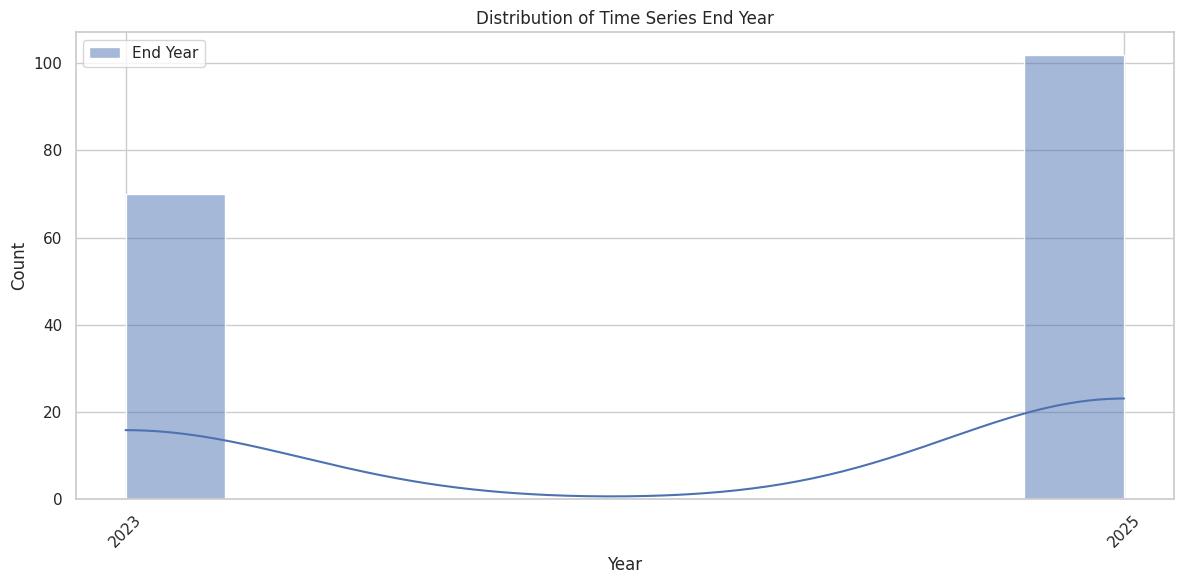

In [16]:
xticks = sorted(df_metadata["end_period_year"].unique())
xtick_labels = [str(year) for year in xticks]
caueduti.plot_histograms(
    data_series=[df_metadata["end_period_year"]],
    labels=["End Year"],
    colors=["C0"],
    bins=10,
    kde=True,
    xlabel="Year",
    title="Distribution of Time Series End Year",
    xticks=xticks,
    xtick_labels=xtick_labels,
    xticks_rotation=45,
    figsize=(12, 6),
)

#### Distribution of Time Series End Year by Frequency

Breaking down end years by frequency reveals that all series ending in 2023 are annual, while those ending in 2025 include monthly, quarterly, and daily series. This pattern confirms that the 2023 values are likely due to update delays rather than discontinuation. Therefore, we can assume that all time series are still active and not discontinued, just pending the next annual update.

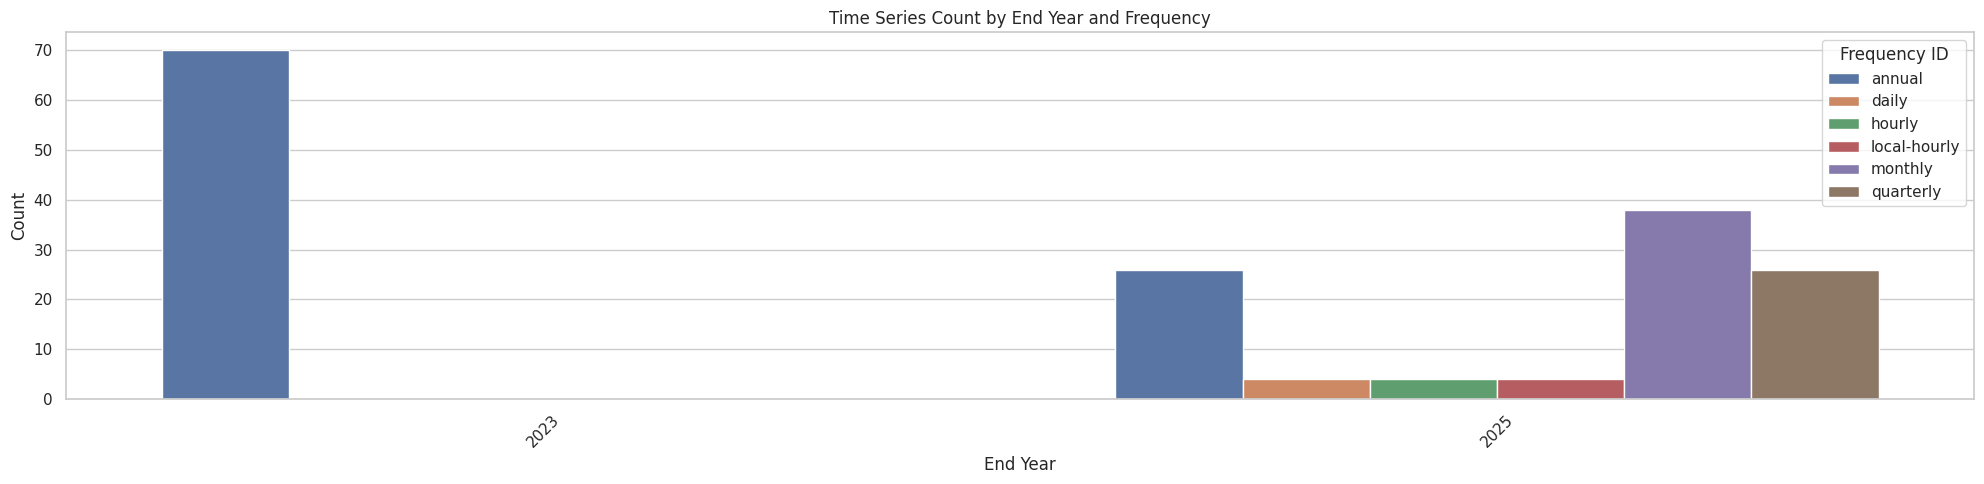

In [17]:
# Count time series by end period and frequency.
df_counts = (
    df_metadata.groupby(["end_period_year", "frequency_id"])
    .size()
    .reset_index(name="count")
)
# Plot grouped barplot.
sns.barplot(data=df_counts, x="end_period_year", y="count", hue="frequency_id")
plt.title("Time Series Count by End Year and Frequency")
plt.xlabel("End Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Frequency ID")
plt.tight_layout()
plt.show()

<a name='facet-analysis'></a>
### Facet Analysis

<a name='top-facets'></a>
#### Top Facets

The distribution of facets used across EIA time series reveals that `stateid` is by far the most common, appearing in nearly 93% of series, indicating strong geographic granularity. Other frequently used facets include `sectorid` and `fueltypeid`, suggesting that categorization by usage sector and fuel classification is also central to the dataset structure. The presence of technical identifiers like `plantCode`, `generatorid`, and `primeMover` highlights the detailed operational scope of certain datasets. Overall, the top 15 facets cover over 250% of the time series, confirming that most series are tagged with multiple dimensions for richer filtering and analysis.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Top Facets Used in EIA Time Series'}, xlabel='Facet ID', ylabel='Count'>)

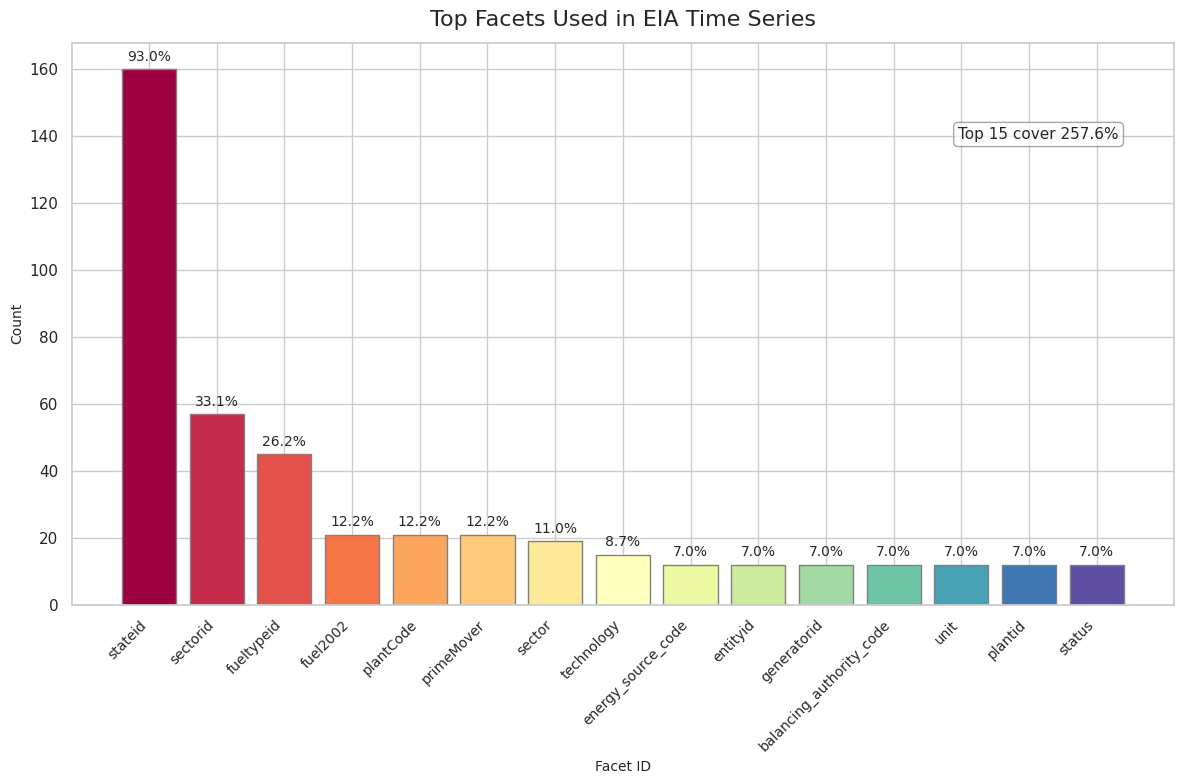

In [18]:
# Calculate facets count.
df_facet = df_metadata[["facets"]].explode("facets").copy()
df_facet["facet_id"] = df_facet["facets"].map(lambda f: f["id"])
facet_counts = df_facet.groupby("facet_id").size().sort_values(ascending=False)
# Plot bar chart of top facets.
caueduti.plot_top_n_annotated_bar(
    counts=facet_counts,
    total=len(df_metadata),
    top_n=15,
    title="Top Facets Used in EIA Time Series",
    xlabel="Facet ID",
    ylabel="Count",
    rotation=45,
    wrap_width=30,
)

<a name='facet-usage-across-dataset'></a>
#### Facet Usage Across Dataset

The heatmap visualizes the presence or absence of each facet ID across EIA datasets. Some facets like `stateid`, `sectorid`, and `plantCode` appear across multiple datasets, highlighting their importance in disaggregating and analyzing energy data. Conversely, many datasets use a small, distinct subset of facets—suggesting that different datasets are specialized for particular use cases. For example, `operating_generator_capacity` is richly annotated, while others like `summary` or `source_disposition` are more minimalistic. This heterogeneity underscores the need for dataset-specific handling when performing cross-dataset analysis.

(<Figure size 1800x1000 with 2 Axes>,
 <Axes: title={'center': 'Facet Usage Across Datasets'}, xlabel='Facet ID', ylabel='Dataset ID'>)

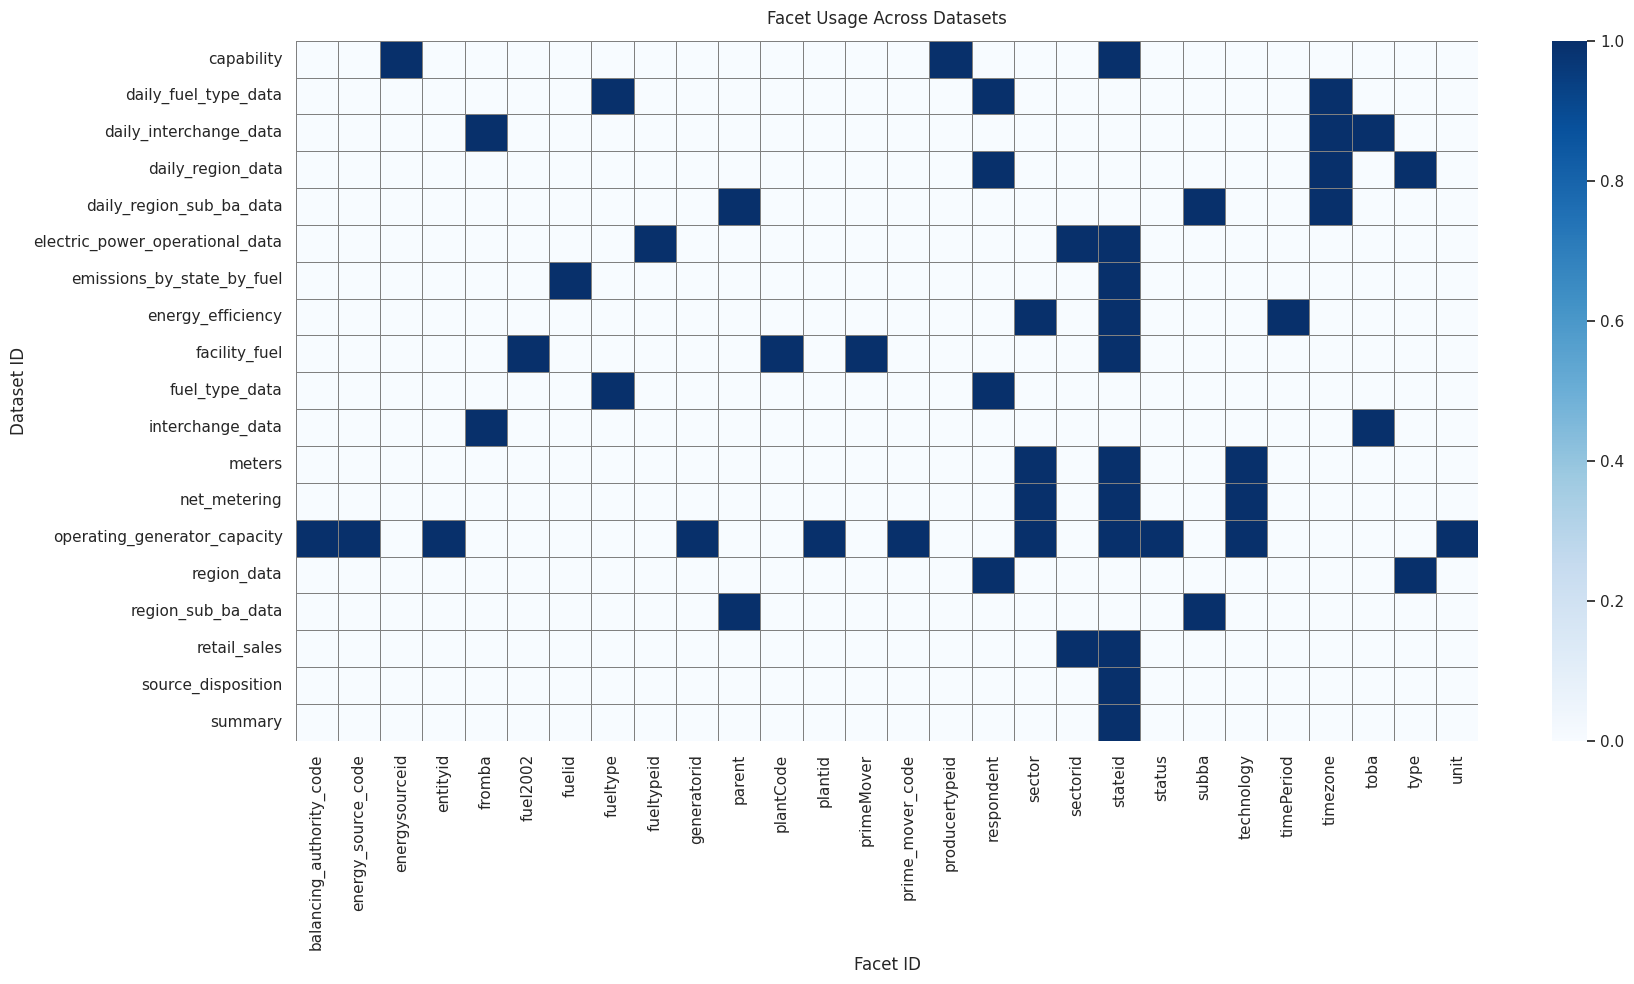

In [19]:
# Create data pairing dataset and facets.
df_dataset_facet = (
    df_metadata[["dataset_id", "facets"]]
    .explode("facets")
    .assign(facet_id=lambda d: d["facets"].map(lambda f: f["id"]))
    .drop(columns="facets")
    .drop_duplicates()
)
# Create crosstab of facet presence per dataset.
facet_crosstab = pd.crosstab(
    df_dataset_facet["dataset_id"], df_dataset_facet["facet_id"]
)
# Plot heatmap of dataset and facet pair.
caueduti.plot_heatmap(
    matrix=facet_crosstab,
    title="Facet Usage Across Datasets",
    xlabel="Facet ID",
    ylabel="Dataset ID",
    fmt="d",
    cmap="Blues",
    annot=False,
    figsize=(18, 10),
    linewidths=0.5,
    linecolor="gray",
    square=False,
)

<a name='facet-cardinalities'></a>
#### Facet Cardinalities

The graph shows the number of unique values each facet contributes across EIA datasets. It reveals that a small number of identifier-like facets dominate the total unique value count, while most facets have relatively low cardinality suited for grouping or filtering.

- **Heavy Skew in Cardinality**: The facets `plantid`, `plantcode`, and `generatorid` dominate, together accounting for over 80% of all unique values, suggesting they are used as fine-grained technical identifiers.
- **Interpretability Gap**: These high-cardinality facets likely represent internal or technical identifiers, whereas lower-cardinality facets such as `sectorid` or `fueltypeid` are more interpretable and domain-relevant.
- **Storage Implications**: The disproportionate cardinality in a few facets can strain indexing and querying performance.
- **Modeling Caution**: These high-cardinality fields should be handled carefully in data modeling to avoid overfitting or inefficient joins. Facets like `plantid` may lead to row explosion in joins if not normalized or managed properly.

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Number of Unique Values per Facet (EIA)'}, xlabel='Facet ID', ylabel='Unique Value Count'>)

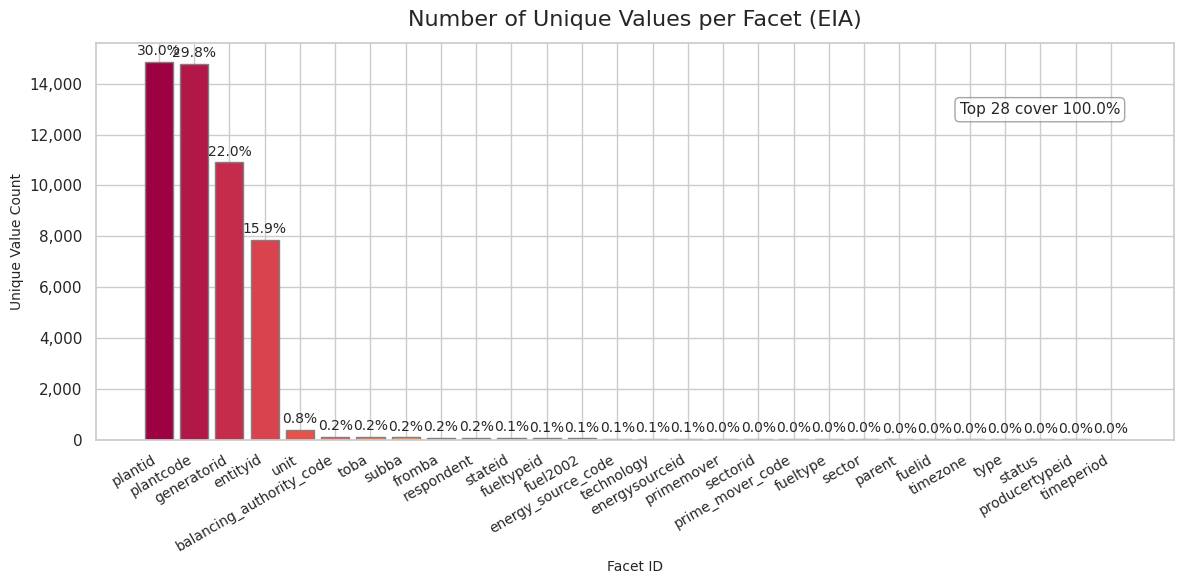

In [20]:
# Combine all parameter data.
df_all_params = pd.concat(param_dfs.values(), ignore_index=True)
# Compute number of unique values per facet ID.
facet_cardinalities = (
    df_all_params.groupby("facet_id")["id"].nunique().sort_values(ascending=False)
)
# Plot bar chart of unique values.
caueduti.plot_top_n_annotated_bar(
    counts=facet_cardinalities,
    total=facet_cardinalities.sum(),
    top_n=len(facet_cardinalities),
    title="Number of Unique Values per Facet (EIA)",
    xlabel="Facet ID",
    ylabel="Unique Value Count",
    rotation=30,
    wrap_width=30,
    figsize=(12, 6),
)

<a name='summary-dataset'></a>
### Summary Dataset

<a name='summary-dataset-overview'></a>
#### Summary Dataset Overview

The summary dataset stands out from other electricity datasets in the EIA collection. Unlike metric-specific datasets such as `retail_sales` or `net_generation`, the summary dataset aggregates high-level electricity indicators by state. These include values like total generation, retail sales, and emissions, often paired with comparative insights such as a state’s national rank. All time series in this dataset are reported on an annual basis, providing a consistent structure suitable for both cross-state and year-over-year comparisons. While most datasets use standard units (e.g., `MWh`, `dollars`), the summary dataset includes non-standard units such as `rank`, reinforcing its analytical and comparative purpose. The dataset presents standalone summary insights that aren't tied to a single physical measurement.

In [21]:
# Preview summary dataset.
df_summary = df_metadata[df_metadata["dataset_id"] == "summary"]
df_summary.head()

,url,id,dataset_id,name,description,frequency_id,frequency_alias,frequency_description,frequency_query,frequency_format,facets,data,data_alias,data_units,start_period,end_period,parameter_values_file,start_period_year,end_period_year,timespan_years
137,https://api.eia.gov/v2/electricity/state-elect...,summary_annual_net_summer_capacity,summary,State Rankings for Key Statistics,State rankings for key electricity statistics ...,annual,NaN,One data point for each calendar year.,A,YYYY,"[{'id': 'stateid', 'description': 'State'}]",net-summer-capacity,"Net Summer Capacity, All Sectors",megawatts,2008,2023,eia_parameters_v1.0/summary_parameters.csv,2008,2023,15
138,https://api.eia.gov/v2/electricity/state-elect...,summary_annual_net_summer_capacity_rank,summary,State Rankings for Key Statistics,State rankings for key electricity statistics ...,annual,NaN,One data point for each calendar year.,A,YYYY,"[{'id': 'stateid', 'description': 'State'}]",net-summer-capacity-rank,"Net Summer Capacity, All Sectors (U.S. Rank)",rank,2008,2023,eia_parameters_v1.0/summary_parameters.csv,2008,2023,15
139,https://api.eia.gov/v2/electricity/state-elect...,summary_annual_capacity_elec_utilities,summary,State Rankings for Key Statistics,State rankings for key electricity statistics ...,annual,NaN,One data point for each calendar year.,A,YYYY,"[{'id': 'stateid', 'description': 'State'}]",capacity-elec-utilities,"Net Summer Capacity, Electric Power Sector",megawatts,2008,2023,eia_parameters_v1.0/summary_parameters.csv,2008,2023,15
140,https://api.eia.gov/v2/electricity/state-elect...,summary_annual_capacity_elect_utilities_rank,summary,State Rankings for Key Statistics,State rankings for key electricity statistics ...,annual,NaN,One data point for each calendar year.,A,YYYY,"[{'id': 'stateid', 'description': 'State'}]",capacity-elect-utilities-rank,Average Retail Price of Electricity (U.S. Rank),rank,2008,2023,eia_parameters_v1.0/summary_parameters.csv,2008,2023,15
141,https://api.eia.gov/v2/electricity/state-elect...,summary_annual_capacity_ipp,summary,State Rankings for Key Statistics,State rankings for key electricity statistics ...,annual,NaN,One data point for each calendar year.,A,YYYY,"[{'id': 'stateid', 'description': 'State'}]",capacity-ipp,"Net Summer Capacity, Independent Power Produce...",megawatts,2008,2023,eia_parameters_v1.0/summary_parameters.csv,2008,2023,15


<a name='unit-distribution-in-the-summary-dataset'></a>
#### Unit Distribution in the Summary Dataset

To further understand what the summary dataset measures, we examine the `data_units` column. The most common unit is `rank`, indicating that many series are not raw values but comparative rankings across U.S. states. In addition, for every metric with a standard unit (e.g., `megawatts` or `short tons`), there exists a correlated time series using `rank`, representing the same metric but in relative terms (e.g., `net-summer-capacity` and `net-summer-capacity-rank`). This pairing reinforces the dataset's role as a state-level benchmarking tool rather than a source of detailed operational data.

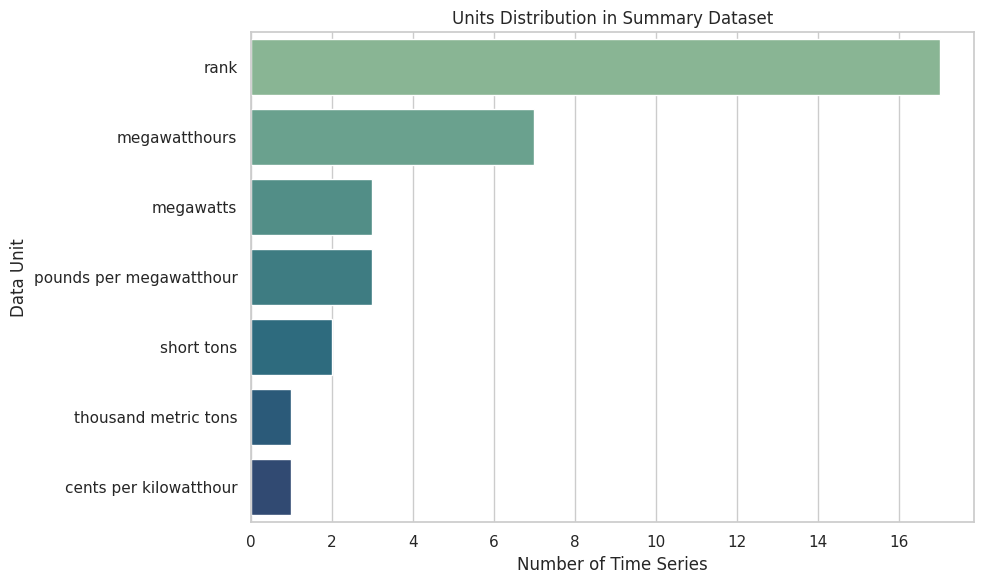

In [22]:
# Count frequency of each unique data unit in the summary metadata
unit_counts = df_summary["data_units"].value_counts()
# Plot the most common data units
plt.figure(figsize=(10, 6))
sns.barplot(
    y=unit_counts.index,
    x=unit_counts.values,
    hue=unit_counts.index,
    palette="crest",
)
plt.title("Units Distribution in Summary Dataset")
plt.xlabel("Number of Time Series")
plt.ylabel("Data Unit")
plt.tight_layout()
plt.show()